# Implementação básica do algoritmo k-means

Em grande parte baseada na implementação disponível em [dataquestio/kmeans](https://github.com/dataquestio/project-walkthroughs/tree/master/kmeans)

## Imports e Variáveis Globais

In [9]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output



PLOT_RESULTS = True
DEBUG = True

N = 100000
D = 7

K = 5
MAX_ITERATIONS = 500

## Criando o Dataset

- `N` datapoints
- Datapoints `D`-dimensionais
- Floats randomizados ➡ intervalo de [1, 10) (ou [1, 10], dependendo da método de arredondamento de float usado. Isto não deve ter nenhuma relevância estatística, no entanto)

In [10]:
dataset  = [[np.random.uniform(1, 10) for _ in range(D)] for _ in range(N)]
dataset = pd.DataFrame(dataset, columns=[f'd{i}' for i in range(D)])
dataset

,d0,d1,d2,d3,d4,d5,d6
0,1.416383,7.343684,8.983892,7.932717,3.501232,1.982394,5.635693
1,9.278427,8.497605,3.130304,3.386101,9.886155,7.393688,7.717045
2,3.579758,9.345491,5.855661,8.357802,9.188389,8.577835,2.508293
3,9.170666,3.244218,5.952428,2.199644,3.454163,3.162274,4.537761
4,3.676534,3.414504,4.810625,4.545159,8.680359,8.566851,5.235687
...,...,...,...,...,...,...,...
99995,4.245299,8.693040,5.541131,9.134143,5.976805,3.728710,8.217106
99996,6.198224,4.465564,7.175790,8.322717,3.136284,2.598051,1.230700
99997,3.721794,3.191218,2.283511,3.457913,8.663062,9.672658,6.306015
99998,6.220805,7.979918,5.288108,9.526290,6.206096,9.491464,8.758230


## K-Means (CPU)

In [11]:
def kMeansCPU(dataset:pd.DataFrame, k=3, maxIter=100, plotResults=False, debug=False):
    if plotResults:
        # Inicializando variáveis para exibição gráfica
        pca = PCA(n_components=2) # dois eixos no gráfico
        dataset_2D = pca.fit_transform(dataset)

    # Gerando centróides iniciais randomicamente
    centroids = pd.concat([(dataset.apply(lambda x: float(x.sample().iloc[0]))) for _ in range(k)], axis=1) # * Paralelizar isto provavelmente é irrelevante, visto que sempre teremos poucos centróides
    centroids_OLD = pd.DataFrame()

    iteration = 1

    while iteration <= maxIter and not centroids_OLD.equals(centroids):
        if plotResults or debug: clear_output(wait=True)
        if debug: debugStr = f'Iteration {iteration}\n\nCentroids:\n{centroids.T}\n\n'

        # Para cada datapoint, calcular distâncias entre ele e cada centróide; depois, encontrar o centróide mais próximo e salvar seu index
        distances = centroids.apply(lambda x: np.sqrt(((dataset - x) ** 2).sum(axis=1))) # ! Parte altamente paralelizável!
        if debug: debugStr += f'Distances:\n{distances}\n\n'
        closestCent = distances.idxmin(axis=1)
        del distances
        if debug: debugStr += f'Closest centroid index:\n{closestCent}\n\n'

        centroids_OLD = centroids
        centroids = dataset.groupby(closestCent).apply(lambda x: np.exp(np.log(x).mean())).T # ! Parte altamente paralelizável!

        if plotResults:
            # Plotando clusters
            centroids_2D = pca.transform(centroids.T)
            plt.title(f'Iteration {iteration}')
            plt.scatter(x=dataset_2D[:,0], y=dataset_2D[:,1], c=closestCent)
            plt.scatter(x=centroids_2D[:,0], y=centroids_2D[:,1], marker='+', linewidths=2, color='red')
            plt.show()

        if debug: print(debugStr)

        iteration += 1

    return closestCent

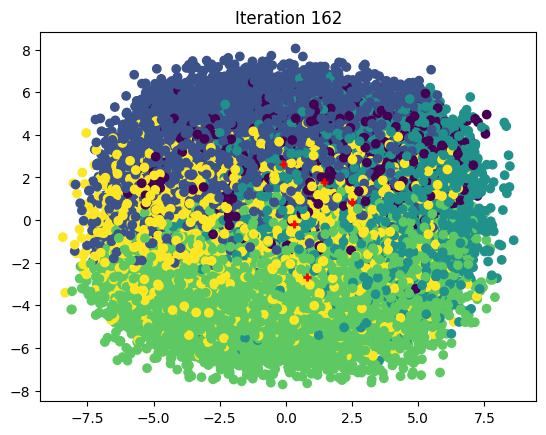

Iteration 162

Centroids:
         d0        d1        d2        d3        d4        d5        d6
0  2.982789  4.760809  2.838036  4.509045  2.725725  3.116764  4.807312
1  3.599862  4.949191  8.236731  4.822503  4.619530  3.826153  4.837280
2  3.741096  4.563676  3.370447  4.698787  8.241561  3.892990  4.603263
3  4.706669  4.711209  4.527394  4.787536  4.443282  8.430035  4.819326
4  8.356842  4.784698  4.660974  4.776382  4.363559  3.837835  4.706739

Distances:
               0          1          2         3          4
0       7.822555   5.101015   9.071319  9.520212   9.403067
1      11.531500  11.033308   8.519029  8.845863   8.433026
2      11.053029   9.293698   8.348031  8.070709  10.414170
3       7.498533   6.922915   8.221372  7.721022   3.557353
4       8.457591   7.300654   5.085268  4.585465   8.070732
...          ...        ...        ...       ...        ...
99995   8.265912   7.318771   7.739903  8.484548   8.178131
99996   7.550905   6.089183   8.530857  8.390179  

In [12]:
# ! Descomente para rodar de fato
# result = kMeansCPU(dataset, K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)

# Testando com um Dataset Real (Pequeno) — *Iris*

Vamos agora testar esta implementação do k-means usando um dataset real de tamanho bem trivial.

Utilizaremos o [*Iris* Data Set](https://archive.ics.uci.edu/ml/datasets/Iris), que consiste de dados a respeito de espécimes de [flores do gênero Íris](https://pt.wikipedia.org/wiki/Iris_(g%C3%A9nero)), popularmente chamadas de **Lírios**.

## Dataset

O *Iris* consiste em **150 instâncias**, com dados multivariados de **quatro atributos**:

1. Comprimento da sépala em centímetros
2. Largura da sépala em centímetros
3. Comprimento da pétala em centímetros
4. Largura da pétala em centímetros

Há também um quinto atributo de **Classe**, o **tipo da planta**, que é o que esperamos predizer utilizando o algoritmo. Há **três classes** neste dataset:

- Iris Setosa
- Iris Versicolour
- Iris Virginica

Assim, temos nossas variáveis para execução do k-means:

- `N` = 150
- `D` = 4
- `K` = 3

### Carregando o Dataset

In [13]:
# Imports
from os.path import exists as os_path_exists
from urllib.request import urlopen



# Novas variáveis globais
MAX_ITERATIONS = 100
PLOT_RESULTS = True
DEBUG = True
# ? K será inferido pela quantidade de classes no dataset
# // K = 3



# Função auxiliar
def downloadFileIfNeeded(filePath, url):
    if not os_path_exists(filePath):
        with urlopen(url) as f:
            html = f.read().decode('utf-8')
        with open(filePath, 'w') as f:
            f.write(html)



datasetUrl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
datasetFilePath = './iris.data'
columnNames = ['sepalLen', 'sepalWid', 'petalLen', 'petalWid', 'class']

# Baixando dataset diretamente da internet, se necessário
downloadFileIfNeeded(datasetFilePath, datasetUrl)

# Lendo dataset do arquivo
with open(datasetFilePath, 'r') as datasetFile:
    dataset = pd.read_csv(datasetFilePath, names=columnNames)

print(dataset)

     sepalLen  sepalWid  petalLen  petalWid           class
0         5.1       3.5       1.4       0.2     Iris-setosa
1         4.9       3.0       1.4       0.2     Iris-setosa
2         4.7       3.2       1.3       0.2     Iris-setosa
3         4.6       3.1       1.5       0.2     Iris-setosa
4         5.0       3.6       1.4       0.2     Iris-setosa
..        ...       ...       ...       ...             ...
145       6.7       3.0       5.2       2.3  Iris-virginica
146       6.3       2.5       5.0       1.9  Iris-virginica
147       6.5       3.0       5.2       2.0  Iris-virginica
148       6.2       3.4       5.4       2.3  Iris-virginica
149       5.9       3.0       5.1       1.8  Iris-virginica

[150 rows x 5 columns]


### Preparando o Dataset

In [27]:
# Transformando a coluna "class" em números (0, 1, …)
classFactorized = dataset['class'].factorize()
# Salvando os nomes de classe na ordem usada pelo .factorize()
classes = list(classFactorized[1])
# Sobrescrevendo a coluna do dataset pelos indexes obtidos
dataset['class'] = classFactorized[0]

print(f'##### Dataset #####\n{dataset}\n\n')

# Normalizando o dataset (normalização min-max), para que todos valores estejam no intervalo [1, 10]
dataset = ((dataset - dataset.min()) / (dataset.max() - dataset.min())) * 9 + 1

print(f'##### Dataset (normalizado, intervalo [1, 10]) #####\n{dataset}')

# Inferindo número de grupos pela quantidade de classes no dataset
K = len(classes)

##### Dataset #####
     sepalLen  sepalWid  petalLen  petalWid  class
0        3.00     6.625  1.610169     1.375      0
1        2.50     4.750  1.610169     1.375      0
2        2.00     5.500  1.457627     1.375      0
3        1.75     5.125  1.762712     1.375      0
4        2.75     7.000  1.610169     1.375      0
..        ...       ...       ...       ...    ...
145      7.00     4.750  7.406780     9.250      2
146      6.00     2.875  7.101695     7.750      2
147      6.50     4.750  7.406780     8.125      2
148      5.75     6.250  7.711864     9.250      2
149      5.00     4.750  7.254237     7.375      2

[150 rows x 5 columns]


##### Dataset (normalizado, intervalo [1, 10]) #####
     sepalLen  sepalWid  petalLen  petalWid  class
0        3.00     6.625  1.610169     1.375    1.0
1        2.50     4.750  1.610169     1.375    1.0
2        2.00     5.500  1.457627     1.375    1.0
3        1.75     5.125  1.762712     1.375    1.0
4        2.75     7.000  1.610169 

## Rodando o K-Means

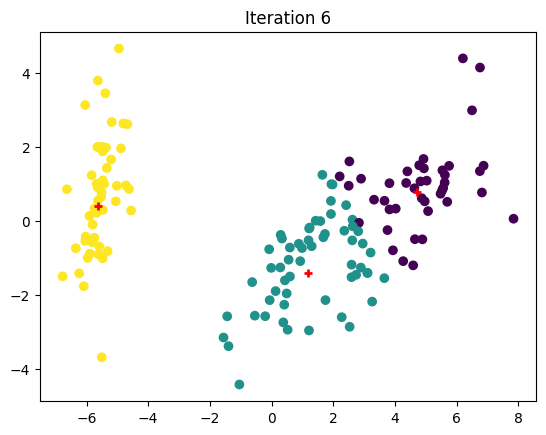

Iteration 6

Centroids:
   sepalLen  sepalWid  petalLen  petalWid
0  7.176057  4.972883  8.028289  8.227307
1  4.774746  3.508828  6.096670  5.815442
2  2.613660  6.143529  1.686990  1.494296

Distances:
             0         1          2
0    10.407464  7.259922   0.633408
1    10.491023  6.823576   1.405338
2    10.825762  7.273392   0.926038
3    10.755315  7.089557   1.342861
4    10.575706  7.492269   0.878785
..         ...       ...        ...
145   1.229979  4.472677  10.679365
146   2.621187  2.579840   9.518584
147   0.950511  3.401096   9.681312
148   2.193329  4.782278  10.310093
149   2.471939  2.315908   8.556487

[150 rows x 3 columns]

Closest centroid index:
0      2
1      2
2      2
3      2
4      2
      ..
145    0
146    1
147    0
148    0
149    1
Length: 150, dtype: int64




In [36]:
# Rodando kMeansCPU, excluindo a coluna class
result = kMeansCPU(dataset.drop(['class'], axis=1), K, MAX_ITERATIONS, PLOT_RESULTS, DEBUG)

## Conferindo Resultados

Com a tabela `ClosestCentroids` em mãos, temos a classificação de cada instância do dataset *Iris* e, assim, podemos conferir os resultados obtidos através do k-means.

Para isto, basta comparar a segunda coluna da tabela devolvida pelo `kMeansCPU()` com a última coluna do dataset Iris, que informa a classe correta de cada instância.